In [9]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [10]:
curve_data = pd.read_csv("../data/curve__data.csv")

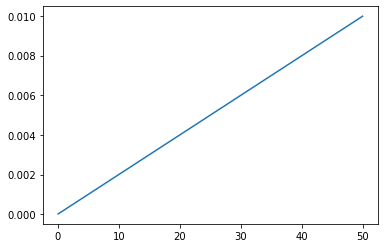

In [11]:
plt.plot(curve_data['timestamps'], curve_data['acceleration_input'])